# Interactive plots in Jupyter notebooks with matplotlib and ipywidgets
## PART I: matplotlib inline backend

Author: DVC  
Date: 01/12/2020   


### Using the inline backend with a GUI ?

The matplotlib inline backend is described as a **non-GUI** backend.  So, why do we insist on using it with a (simple) GUI ?    
- it is the most commonly used backend 
- it is probably the only backend that behaves consistently across platforms  
- what works with the inline backend is almost guaranteed to work with any other backend
- we often need something more fancy than just typing in cells as provided natively in our Jupyter notebooks

What are the opportunities and limitations with the inline backend ?  
- the basic (ipy)widgets work fine in the inline backend, creating some possibilities
- figures are not accessible after being rendered hence they can not be manipulated
- interactivity can only be simulated by redrawing the full figure after each change
    + this is not an issue with slow updates of the controls
    + visual glitches from the clear-and-redraw cycle are inevitable
    + computational load quickly increases for complex applications
    + be aware that a figure is NOT closed after rendering

In [6]:
%matplotlib inline

In [7]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual, interactive
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import IPython.display as ipd

In [ ]:
# any of these could be useful during debugging, but not needed if all is running fine
#
#%matplotlib --list
#ipd.set_matplotlib_close(close=True)
#plt.close('all')

# 1. Updating Figures using a CLEAR-PLOT cycle
### 1.1 Using interact() for the most simple interfaces

In [8]:
plt.close('all')
def my_sine(x, w, amp, phi):
    return amp*np.sin(w * (x-phi))
#
def synth(type='sin', freq=200.0, Fs=8000, Tmax=0.5):
    t = np.linspace(0.0, Tmax, int(Tmax*Fs), endpoint=False)
    if type == 'sin':
        x = np.sin(2.0*np.pi*freq*t)
    elif type == 'square':
        x = signal.square(2.0*np.pi*freq*t)
    elif type == 'sawtooth':
        x = signal.sawtooth(2.0*np.pi*freq*t)
    else:
        print( 'signal: Unrecognized signal type')
    return x, t

In [9]:
# Methodology:
# ============
#  1. Create the Figure
#  2. Use interact() for the interactive Loop:
#       (a) CLEAR FIGURE
#       (b) PLOT AGAIN with each interaction
#
# REMARK: 
#   AVOID following loop construction:
#      (a) create a figure
#      (b) draw to the figure
#   At first sight it behaves the same, but a new figure is created each time
#   and after some time you will run out of available figures as they are not closed automatically

x = np.linspace(0, 2 * np.pi, 100)
fig = plt.figure(figsize=(3,3))

@interact(w=(0, 10, 1), amp=(0, 4, .1), phi=(0, 2*np.pi, 0.01))
def update(w = 1.0, amp=1, phi=0):
    # clear the figure and start over
    plt.clf()
    plt.plot(x, my_sine(x, w, amp, phi), color='C0')
    plt.ylim([-4, 4])
    plt.grid(True)

<Figure size 216x216 with 0 Axes>

interactive(children=(IntSlider(value=1, description='w', max=10), FloatSlider(value=1.0, description='amp', m…

### Using interactive_output() for more control over the layout 

In [27]:
# create the sliders for interaction
wg_amp = widgets.FloatSlider(value=0.5,step=0.05,max=1.0,description='Amplitude')
wg_freq = widgets.FloatSlider(value=1.0,step=.1,min=200.0,max=1000.,description='Frequency')
wg_Tmax = widgets.FloatSlider(value=0.4,step=0.1,min=0.1,max=1.0,description='Duration',
                             continuous_update=False)
box_layout = widgets.Layout(
        border='solid 1px black',
        margin='0px 10px 10px 0px',
        padding='5px 5px 5px 5px'
     )
UI = widgets.HBox( [wg_amp, wg_freq, wg_Tmax] ,layout=box_layout)

# create two output widgets, one for audio and one for plotting
out_audio = widgets.Output()
#out_plot = widgets.Output()
#with out_plot:
fig = plt.figure(figsize=(2,10))

def sin_gui1(amp=1., freq=440.0, Fs=8000, Tmax=1.0):
#    with out_plot:
    plt.clf()
    y,x = synth('sin',freq=freq,Tmax=Tmax)
    y=amp*y
    plt.plot(x, y, color='C0')
    plt.ylim([-1, 1])
    plt.grid(True)
    with out_audio:
        ipd.clear_output()
        try:
            ipd.display(ipd.Audio(data=y,rate=8000,normalize=False, autoplay=True))
        except: 
            try:
              print("Warning: playing normalized sound")
              ipd.display(ipd.Audio(data=y,rate=8000, autoplay=True))
            except: pass
           
out_plot = widgets.interactive_output(sin_gui1, {'amp': wg_amp, 'freq': wg_freq, 'Tmax': wg_Tmax})

Screen = widgets.HBox([ out_plot, out_audio], layout=box_layout)
widgets.VBox([ UI, Screen ])

<Figure size 144x720 with 0 Axes>

In [ ]:
out_plot.children

AttributeError: 'Output' object has no attribute 'children'

In [ ]:
fig.show()

<ipython-input-7-6ebedab27258>:1: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


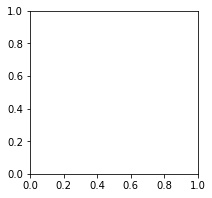

interactive(children=(IntSlider(value=1, description='w', max=10), FloatSlider(value=1.0, description='amp', m…

In [ ]:
# Method 2: CLEAR selected axes and redraw with each operation (use OO API)
# BACKENDS: NOT for INLINE !
def my_sine(x, w, amp, phi):
    return amp*np.sin(w * (x-phi))
#
x = np.linspace(0, 2 * np.pi, 100)
fig, ax = plt.subplots(figsize=(3, 3))

@interact(w=(0, 10, 1), amp=(0, 4, .1), phi=(0, 2*np.pi, 0.01))
def update(w = 1.0, amp=1, phi=0):
    plt.cla()
    ax.plot(x, my_sine(x, w, amp, phi), color='C0')
    ax.set_ylim([-4, 4])
    ax.grid(True)

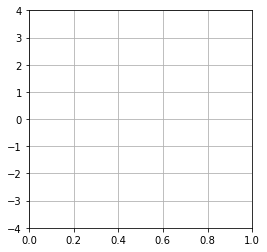

interactive(children=(IntSlider(value=1, description='w', max=10), FloatSlider(value=1.0, description='amp', m…

In [ ]:
# Method 3: Only update line data inside existing axis
# BACKENDS: NOT for INLINE !
# 

def my_sine(x, w, amp, phi):
    return amp*np.sin(w * (x-phi))
#
x = np.linspace(0, 2 * np.pi, 100)
fig, ax = plt.subplots(figsize=(4, 4))
ax.set_ylim([-4, 4])
ax.grid(True)

@interact(w=(0, 10, 1), amp=(0, 4, .1), phi=(0, 2*np.pi, 0.01))
def update(w = 1.0, amp=1, phi=0):
    """Remove old lines from plot and plot new one"""
    [l.remove() for l in ax.lines]
    ax.plot(x, my_sine(x, w, amp, phi), color='C0')

## Updating the plot line data

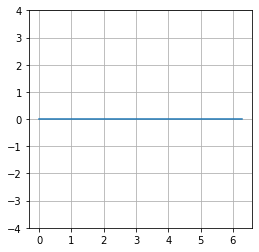

interactive(children=(IntSlider(value=1, description='w', max=10), FloatSlider(value=1.0, description='amp', m…

In [ ]:
# Method 3b: maintain the figure and just refresh the changed data
#    1) create a figure  
#    2)  just update the y_data if you may assume that the x_data hasn't changed; 
#          between calls 
#
# BACKENDS: all, except 'inline'  
# 

def my_sine(x, w, amp, phi):
    """
    Return a sine for x with angular frequeny w and amplitude amp.
    """
    return amp*np.sin(w * (x-phi))
x = np.linspace(0, 2 * np.pi, 100)

#
fig, ax = plt.subplots(figsize=(4, 4))
ax.set_ylim([-4, 4])
ax.grid(True)
line, = ax.plot(x, my_sine(x, 0,0,0), color='C0')

@interact(w=(0, 10, 1), amp=(0, 4, .1), phi=(0, 2*np.pi+0.01, 0.01))
def update(w = 1.0, amp=1, phi=0):
    """change the ydata values """
    line.set_ydata( my_sine(x, w, amp, phi) )
    fig.canvas.draw()
    # fig.canvas.flush_events()

In [ ]:
# a simple audio signal generator
# with control for type amplitude, phase ... 
#
# the audio is immediately generated and rendered
#   continuous update are used for frequency and amplitude
#   continuous_update=False is used for the duration widget
# !! setting continuous_update is the only 'easy' control over frequency of update with interact()
# !! more complex asynchronous implementations are suggested on the ipywidgets doc pages
# !! under 'debouncing' and 'throttling' .. but this complicates the code significantly
# https://ipywidgets.readthedocs.io/en/latest/examples/Widget%20Events.html?highlight=continuous_update#Continuous-updates
# !! these solutions are not applicable to interact(), but require .observe() instead, see later
#
# as the x-axis needs to be modified with the duration
#  it is more appropriate to do full redraws at every iteration
#
# BACKENDS: all
#
samplerate=8000
def generate(type='sin', freq=200.0, Fs=samplerate, Tmax=0.5):
    t = np.linspace(0.0, Tmax, int(Tmax*Fs), endpoint=False)
    if type == 'sin':
        x = np.sin(2.0*np.pi*freq*t)
    elif type == 'square':
        x = signal.square(2.0*np.pi*freq*t)
    elif type == 'sawtooth':
        x = signal.sawtooth(2.0*np.pi*freq*t)
    else:
        print( 'signal: Unrecognized signal type')
    return x, t

signal_types = [ 'sin', 'square', 'sawtooth' ]
# alternative to Dropdown is to use RadioButtons
wg_signal = widgets.Dropdown(options=signal_types,
                             value='sin',description="Signal")
wg_amp = widgets.FloatSlider(value=0.5,step=0.05,max=1.0,description='Amplitude')
wg_freq = widgets.FloatSlider(value=200.0,step=5.0,min=50.0,max=500.0,description='Frequency')
wg_Tmax = widgets.FloatSlider(value=0.4,step=0.1,min=0.1,max=2.0,description='Duration',
                             continuous_update=False)
#wg_check = widgets.Checkbox(description='Display Play Button',value=True)
wg_audio = widgets.Output()
wg_plot = widgets.Output()
with wg_plot:
    fig = plt.figure(figsize=(5,4))
first_time = True

# in this example we use interact and full replotting
# this seems to work well with ALL backends

@interact(t=wg_signal,f=wg_freq,A=wg_amp,T=wg_Tmax)
def plot_fn(t,f,A,T):
    global first_time
    x1, t1 = generate(freq=f,type=t,Tmax=T)
    y1=A*x1
    with wg_plot:
        plt.cla()
        plt.plot(t1,y1)
        plt.ylim(-1,1)
    with wg_audio:
        ipd.clear_output()
        ipd.display(ipd.Audio(data=y1,rate=samplerate,normalize=False, autoplay=True))
    return

#widgets.HBox( [widgets.VBox([wg_signal,wg_freq,wg_amp,wg_Tmax]),widgets.VBox([wg_plot,wg_audio])])
widgets.Box( [wg_plot,wg_audio] )

<Figure size 360x288 with 0 Axes>

interactive(children=(Dropdown(description='Signal', options=('sin', 'square', 'sawtooth'), value='sin'), Floa…

Box(children=(Output(), Output()))

# 2. Using observe() and callbacks for more control over the interaction
## The Output Widget, Widget Boxes, Observers, Classes, ... and fragile backends

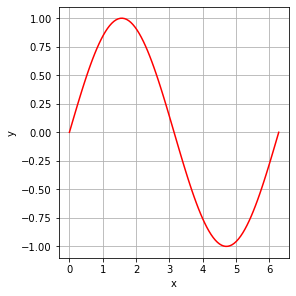

In [ ]:
# create some x data and plot it in the output widget
# give control over data, axis, .. via control widgets using callbacks
#
x = np.linspace(0, 2 * np.pi, 100)
output = widgets.Output() 
with output:
    fig, ax = plt.subplots(constrained_layout=True, figsize=(4, 4))
# move the toolbar to the bottom
fig.canvas.toolbar_position = 'bottom'
ax.grid(True)    
line, = ax.plot(x, np.sin(x), '#FF0000')

# create some control elements
int_slider = widgets.IntSlider(value=1, min=0, max=10, step=1, description='freq')
color_picker = widgets.ColorPicker(value='#FF0000', description='pick a color')
text_xlabel = widgets.Text(value='', description='xlabel', continuous_update=False)
text_ylabel = widgets.Text(value='', description='ylabel', continuous_update=False)
 
# callback functions
def update(change):
    """redraw line (update plot)"""
    line.set_ydata(np.sin(change.new * x))
    fig.canvas.draw()
     
def line_color(change):
    """set line color"""
    line.set_color(change.new)
     
def update_xlabel(change):
    ax.set_xlabel(change.new)
     
def update_ylabel(change):
    ax.set_ylabel(change.new)
 
# connect callbacks and traits
int_slider.observe(update, 'value')
color_picker.observe(line_color, 'value')
text_xlabel.observe(update_xlabel, 'value')
text_ylabel.observe(update_ylabel, 'value')
 
text_xlabel.value = 'x'
text_ylabel.value = 'y'
controls = widgets.VBox([int_slider, color_picker, text_xlabel, text_ylabel])
widgets.HBox([controls, output])

## Packing components in a class
### Leveraging the Output widget, observers, classes, ..
### Dedicated to the 'widget' mpl backend

This is a copy from the Kapernikov tutorial ( https://kapernikov.com/ipywidgets-with-matplotlib/ )

To create more high level components, we can also subclass a container and build up our gui from within. Containers have a `children` property to which we can assign a list of widgets that should be displayed. Although, we can assign a list, this is turned into a tuple and cannot be modified afterwards.
To remove or add a widget at runtime, the children tuple can be turned back into a list, followed by an insert or deletion and finalised by reassigning to the children property. Since it can be easy to make mistakes when going by index, I tend to add a placeholder box in which I only place the 'dynamic' widget.

The example below, packs the entire oscilloscope 'dashboard' in a single component by subclassing `VBox`. All the required widgets are defined in the Sines class and added as its `children`. The callbacks are defined as instance methods. It may not be a masterpiece in object oriented programming, but hopefully it shows the idea of constructing larger reusable components. Note that, we need to call `super().__init__()` from `__init__` to properly initialise the parent class. 

Sines(children=(VBox(children=(IntSlider(value=1, description='freq', max=10), ColorPicker(value='#FF00DD', de…

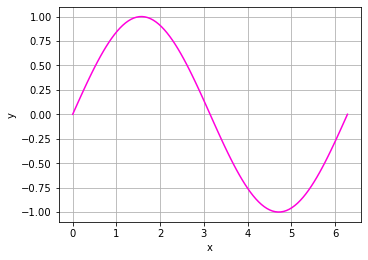

In [ ]:
def make_box_layout():
     return widgets.Layout(
        border='solid 1px black',
        margin='0px 10px 10px 0px',
        padding='5px 5px 5px 5px'
     )

class Sines(widgets.HBox):
    
    def __init__(self):
        super().__init__()
        output = widgets.Output()

        self.x = np.linspace(0, 2 * np.pi, 100)
        initial_color = '#FF00DD'

        with output:
            self.fig, self.ax = plt.subplots(constrained_layout=True, figsize=(5, 3.5))
        self.line, = self.ax.plot(self.x, np.sin(self.x), initial_color)
        
        self.fig.canvas.toolbar_position = 'bottom'
        self.ax.grid(True)

        # define widgets
        int_slider = widgets.IntSlider(
            value=1, 
            min=0, 
            max=10, 
            step=1, 
            description='freq'
        )
        color_picker = widgets.ColorPicker(
            value=initial_color, 
            description='pick a color'
        )
        text_xlabel = widgets.Text(
            value='', 
            description='xlabel', 
            continuous_update=False
        )
        text_ylabel = widgets.Text(
            value='', 
            description='ylabel', 
            continuous_update=False
        )

        controls = widgets.VBox([
            int_slider, 
            color_picker, 
            text_xlabel, 
            text_ylabel
        ])
        controls.layout = make_box_layout()
        
        out_box = widgets.Box([output])
        output.layout = make_box_layout()

        # observe stuff
        int_slider.observe(self.update, 'value')
        color_picker.observe(self.line_color, 'value')
        text_xlabel.observe(self.update_xlabel, 'value')
        text_ylabel.observe(self.update_ylabel, 'value')
        
        text_xlabel.value = 'x'
        text_ylabel.value = 'y'
        

        # add to children
        self.children = [controls, output]
    
    def update(self, change):
        """Draw line in plot"""
        self.line.set_ydata(np.sin(change.new * self.x))
        self.fig.canvas.draw()

    def line_color(self, change):
        self.line.set_color(change.new)

    def update_xlabel(self, change):
        self.ax.set_xlabel(change.new)

    def update_ylabel(self, change):
        self.ax.set_ylabel(change.new)
        
        
Sines()

In [ ]:
# Method 2: CLEAR selected axes and redraw with each operation (use OO API)
# BACKENDS: NOT for INLINE !
def my_sine(x, w, amp, phi):
    return amp*np.sin(w * (x-phi))
#
x = np.linspace(0, 2 * np.pi, 100)
fig= plt.figure(figsize=(3, 3))

@interact(w=(0, 10, 1), amp=(0, 4, .1), phi=(0, 2*np.pi, 0.01))
def update(w = 1.0, amp=1, phi=0):
    plt.clf()
    gs = fig.add_gridspec(2, 1)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[1, 0])
    #ax = fig.add_axes()
    ax1.plot(x, my_sine(x, w, amp, phi), color='C0')
    ax1.set_ylim([-4, 4])
    ax1.grid(True)
    #plt.show()

<Figure size 216x216 with 0 Axes>

interactive(children=(IntSlider(value=1, description='w', max=10), FloatSlider(value=1.0, description='amp', m…